In [1]:
import pandas as pd
import numpy as np
import scipy.stats

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

from IPython.display import display
pd.options.display.max_columns = None

import warnings
warnings.simplefilter('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    print('CONFUSION MATRIX TEST\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [4]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### 1. Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Загрузка данных**

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [8]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### 2. Обработка выбросов и заполнение пустых значений

In [12]:
def data_change (dataframe=df_train):
    dataframe.loc[dataframe['Credit Score'] > 6000, 'Credit Score'] = 0

In [13]:
def fill_na (dataframe=df_train, train_data=df_train):
    dataframe['Annual Income'].fillna(train_data['Annual Income'].median(), inplace=True)
    dataframe['Months since last delinquent'].fillna(train_data['Months since last delinquent'].median(), inplace=True)
    dataframe['Bankruptcies'].fillna(0, inplace=True)
    dataframe['Credit Score'].fillna(train_data['Credit Score'].mean(), inplace=True)
    dataframe['Years in current job'].fillna('10+ years', inplace=True)

### 3. Отбор признаков

Конвертируем признаки 'Years in current job' и 'Term' из типа object в числовой

In [14]:
def conv_object_to_num (dataframe=df_train):
    label_encoder = LabelEncoder()
    label_encoder.fit(dataframe['Years in current job'])
    label_encoded_years = label_encoder.transform(dataframe['Years in current job'])
    dataframe['Years in current job']=label_encoded_years
    label_encoder.fit(dataframe['Term'])
    label_encoded_term = label_encoder.transform(dataframe['Term'])
    dataframe['Term']=label_encoded_term

Создаем несколько синтетических переменных (при их добавлении метрика f1 увеличилась)

In [15]:
def add_new_features (dataframe=df_train):
    dataframe['Maximum Open Credit / Current Loan Amount']= dataframe['Maximum Open Credit'] / dataframe['Current Loan Amount']
    dataframe['Current Loan Amount / Current Credit Balance']= dataframe['Current Loan Amount'] / dataframe['Current Credit Balance']
    dataframe['Annual Income / Maximum Open Credit']= dataframe['Annual Income'] / dataframe['Maximum Open Credit']
    dataframe['Annual Income / Current Loan Amount']= dataframe['Annual Income'] / dataframe['Current Loan Amount']
    dataframe['Credit Score / Annual Income']= dataframe['Credit Score'] / dataframe['Annual Income']

In [16]:
data_change (dataframe=df_train)
fill_na (dataframe=df_train, train_data=df_train)
conv_object_to_num (dataframe=df_train)
add_new_features (dataframe=df_train)

Остальные признаки типа object превращаем в дамми

In [17]:
df_train = pd.get_dummies(df_train)

In [18]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

Строим график корреляции признаков

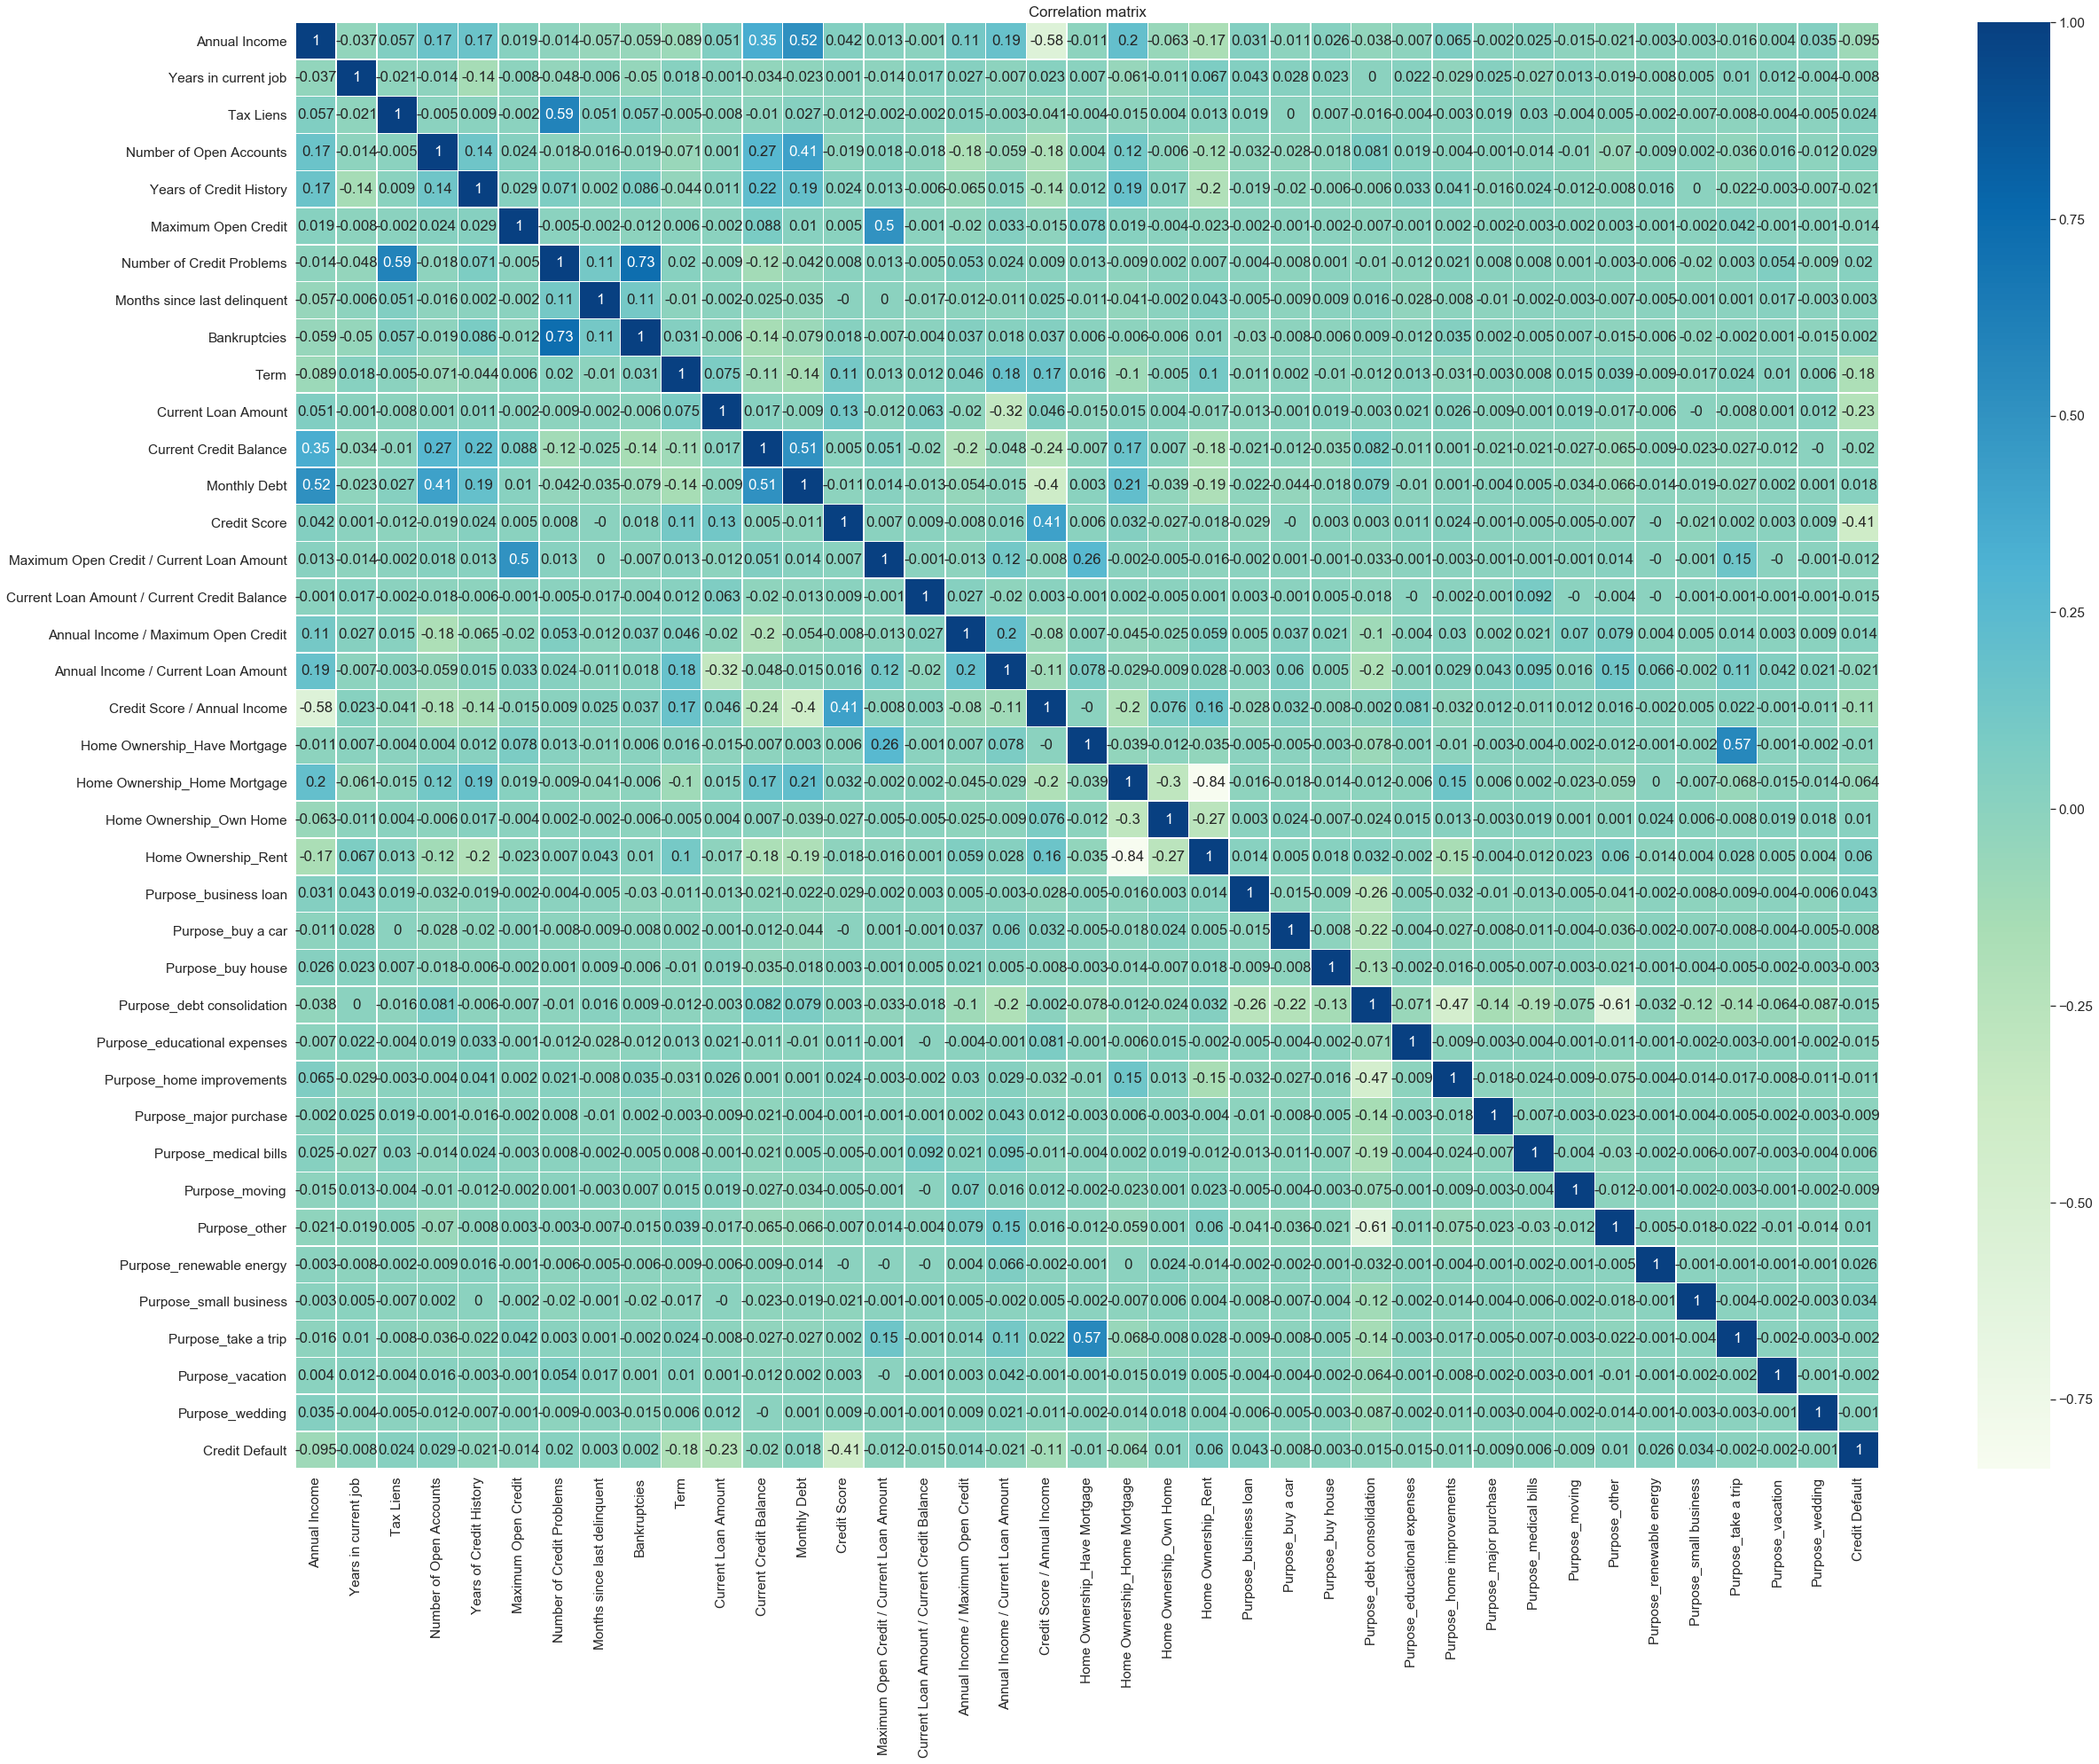

In [19]:
plt.figure(figsize = (40,30))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Разбиваем датасет

In [20]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

### 4. Создание модели

Выбираем XGBClassifier против LGBMClassifier т.к. на тестах показал себя точнее и данный датасет не очень большой

### XGBClassifier

In [21]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [22]:
model_xgb = xgb.XGBClassifier(learning_rate = 0.01,
                              max_depth = 1, 
                              n_estimators = 3000,
                              subsample = 0.5,
                              reg_alpha = 8,
                              reg_lambda = 20,
                              n_jobs = -1,
                              random_state = 21)
model_xgb.fit(X_train, y_train, eval_metric="aucpr", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=8,
              reg_lambda=20, scale_pos_weight=1, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

Порог взят в 0.33 из графиков ниже

In [23]:
y_train_pred_proba_xgb = model_xgb.predict_proba(X_train)
y_train_pred_xgb = (y_train_pred_proba_xgb[:,1] > 0.33)

y_test_pred_proba_xgb = model_xgb.predict_proba(X_test)
y_test_pred_xgb = (y_test_pred_proba_xgb[:,1] > 0.33)

get_classification_report(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4046
           1       0.56      0.59      0.57      1579

    accuracy                           0.76      5625
   macro avg       0.70      0.70      0.70      5625
weighted avg       0.76      0.76      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1341
           1       0.53      0.54      0.53       534

    accuracy                           0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0           False  True 
Credit Default              
0                1079    262
1                 244    290


In [24]:
result = model_xgb.evals_result()
print(max(result['validation_0']['aucpr']))
print(max(result['validation_1']['aucpr']))

0.657708
0.633984


In [25]:
f1_score(y_test, y_test_pred_xgb)

0.5340699815837936

#### Метрика f1, precision и recall >0.5

### Далее строим несколько графиков для анализа полученых результатов и выбора порога.

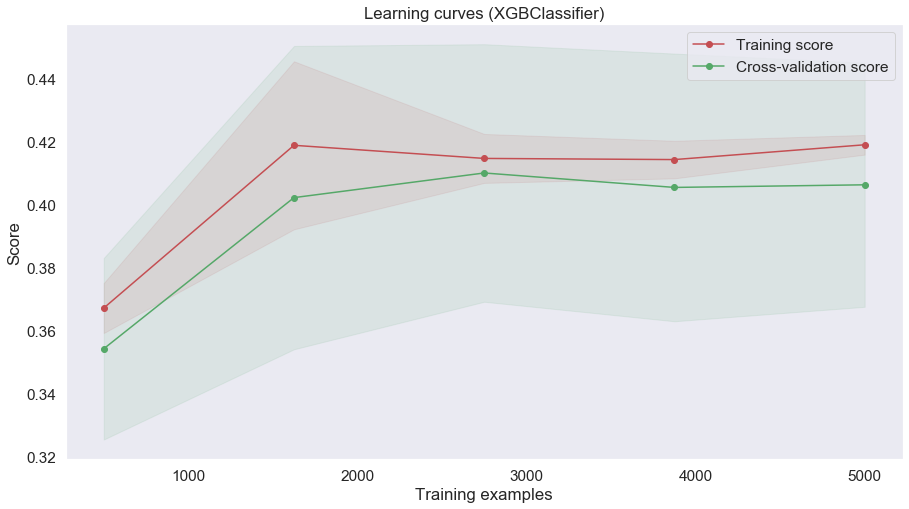

In [26]:
show_learning_curve_plot(model_xgb, X, y)

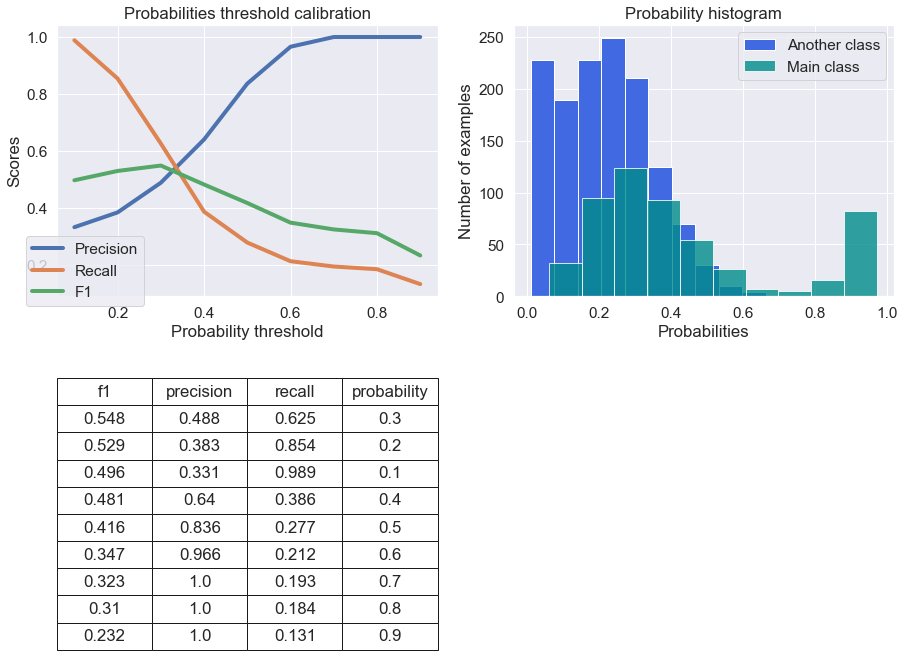

In [27]:
show_proba_calibration_plots(y_test_pred_proba_xgb[:, 1], y_test)

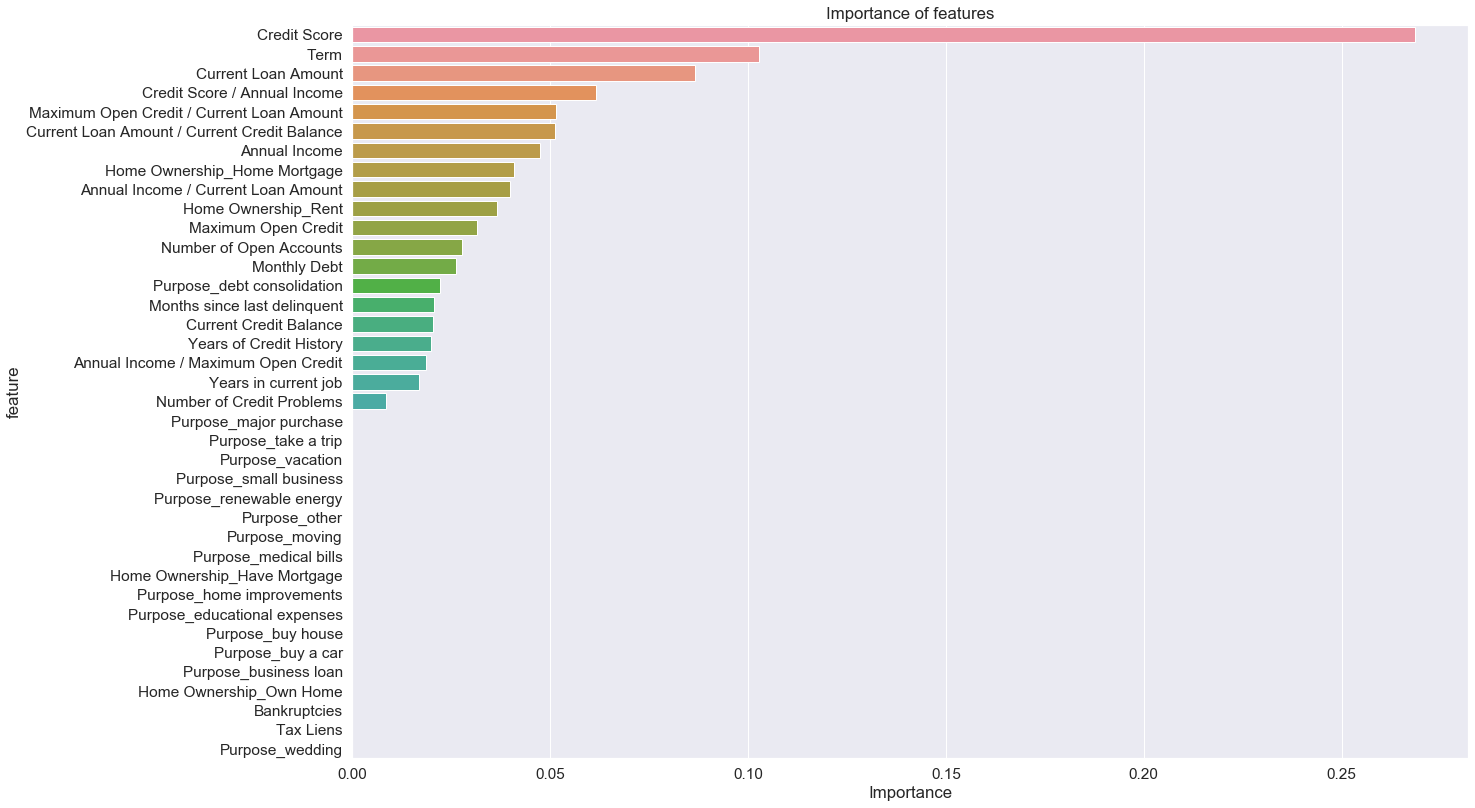

In [28]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=20)

### Далее строим модель на 100% тренировочного датасета на основе 20 важных признаков

In [29]:
X = df_train[important_features_top]
y = df_train[TARGET_NAME]
model_xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=8,
              reg_lambda=20, scale_pos_weight=1, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

### Предсказание на тестовом датасете

In [30]:
data_change (dataframe=df_test)
fill_na (dataframe=df_test, train_data=df_train)
conv_object_to_num (dataframe=df_test)
add_new_features (dataframe=df_test)

In [31]:
df_test = pd.get_dummies(df_test)

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annual Income                                 2500 non-null   float64
 1   Years in current job                          2500 non-null   int32  
 2   Tax Liens                                     2500 non-null   float64
 3   Number of Open Accounts                       2500 non-null   float64
 4   Years of Credit History                       2500 non-null   float64
 5   Maximum Open Credit                           2500 non-null   float64
 6   Number of Credit Problems                     2500 non-null   float64
 7   Months since last delinquent                  2500 non-null   float64
 8   Bankruptcies                                  2500 non-null   float64
 9   Term                                          2500 non-null   i

In [33]:
df_test.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Maximum Open Credit / Current Loan Amount,Current Loan Amount / Current Credit Balance,Annual Income / Maximum Open Credit,Annual Income / Current Loan Amount,Credit Score / Annual Income,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
count,2.500000e+03,2500.0000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.00000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.326182e+06,3.6304,0.035200,11.184400,18.325920,7.105704e+05,0.162000,32.99640,0.106800,0.744400,1.215572e+07,2.963966e+05,18271.340000,664.349039,2.656059,inf,inf,5.313459,0.000627,0.002800,0.49,0.09920,0.408000,0.012000,0.013600,0.007600,0.789200,0.001200,0.056000,0.003600,0.010800,0.0004,0.09600,0.002000,0.005600,0.001200,0.000800
std,8.215127e+05,3.1542,0.386291,4.852774,7.254659,1.511983e+06,0.559894,14.92163,0.356994,0.436285,3.226097e+07,3.783020e+05,11543.881469,176.381537,9.184971,NaN,NaN,6.944186,0.000408,0.052851,0.50,0.29899,0.491561,0.108907,0.115846,0.086863,0.407958,0.034627,0.229968,0.059904,0.103381,0.0200,0.29465,0.044686,0.074638,0.034627,0.028279
min,1.065330e+05,0.0000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,0.000000,0.000000,0.017220,0.047422,0.001065,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,9.365622e+05,1.0000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,32.00000,0.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,672.198048,0.826227,0.902805,1.496058,2.489837,0.000436,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,2.0000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,32.00000,0.000000,1.000000,3.223660e+05,2.073850e+05,16642.500000,715.000000,1.519921,1.405224,2.434214,3.655752,0.000575,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.488726e+06,6.0000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,32.00000,0.000000,1.000000,5.225825e+05,3.663485e+05,24146.000000,737.000000,2.603534,2.988104,4.040256,6.004297,0.000745,0.000000,1.00,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.497561e+07,10.0000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.00000,5.000000,1.000000,1.000000e+08,6.030087e+06,93555.000000,751.000000,397.650336,inf,inf,149.685416,0.006993,1.000000,1.00,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000,1.000000,1.000000,1.000000


In [34]:
test_pred_proba_xgb = model_xgb.predict_proba(df_test[important_features_top])
test_pred_xgb = pd.Series(data=((test_pred_proba_xgb[:,1] > 0.33)*1), name='Credit Default')

In [35]:
test_pred_xgb.to_csv('EShenk_predictions.csv',index=False)

In [36]:
pd.read_csv('EShenk_predictions.csv')

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,0
2498,0
